In [1]:
import os
import datetime
import errno

import numpy as np

import deepcell
from deepcell.utils.tracking_utils import load_trks, trks_stats
from deepcell.utils.misc_utils import sorted_nicely
from deepcell.utils.tracking_utils import load_trks

import numpy as np
from skimage.measure import label
from skimage import morphology
import matplotlib.pyplot as plt

In [2]:
from deepcell.utils.data_utils import get_data
from tensorflow.keras.utils import get_file

def load_data(path, mode, test_size=0.2, seed=0):
    """Loads dataset.
    Args:
         test_size (float): fraction of data to reserve as test data
        seed (int): the seed for randomly shuffling the dataset
    Returns:
           tuple: (x_train, y_train), (x_test, y_test).
    """
    basepath = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
    prefix = path.split(os.path.sep)[:-1]
    data_dir = os.path.join(basepath, *prefix) if prefix else basepath
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    elif not os.path.isdir(data_dir):
        raise IOError('{} exists but is not a directory'.format(data_dir))

    train_dict, test_dict = get_data(
        path,
        mode=mode,
        test_size=test_size,
        seed=seed)
    x_train, y_train = train_dict['X'], train_dict['y']
    x_test, y_test = test_dict['X'], test_dict['y']
    return (x_train, y_train), (x_test, y_test)

## FGBG model

In [3]:
norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data  ## 61
n_skips = 1  # number of skip-connections (only for FC training)

# pixelwise transform settings
dilation_radius = 1  # change dilation radius for edge dilation
separate_edge_classes = True  # break edges into cell-background edge, cell-cell edge
pixelwise_kwargs = {
    'dilation_radius': dilation_radius,
    'separate_edge_classes': separate_edge_classes,
}

input_shape=(530, 530, 1)

from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    norm_method=norm_method,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=input_shape,
    last_only=False)

2021-08-27 13:18:33.695682: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-08-27 13:18:33.699896: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-27 13:18:33.724100: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2000170000 Hz
2021-08-27 13:18:33.729764: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x557040f319d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-27 13:18:33.729787: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-08-27 13:18:33.731511: I tensorflow/co

In [4]:
fgbg_model.load_weights("../seg_training/attempt_1/models/test/conv_fgbg_model.h5")

## Pixel-wise model

In [5]:
pixelwise_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    n_features=4 if separate_edge_classes else 3,
    receptive_field=receptive_field,
    norm_method=norm_method,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    last_only=False,
    input_shape=input_shape)

In [6]:
pixelwise_model.load_weights("../seg_training/attempt_1/models/test/conv_edgeseg_model.h5")

In [ ]:
# Segmentation starts

In [52]:
x = np.load("../22956819/A6_raw_4.npy")
x.shape

(100, 530, 530, 1)

In [53]:
images = pixelwise_model.predict(x)[-1]
images_fgbg = fgbg_model.predict(x)[-1]

In [54]:
threshold = 0.8

fg_thresh = images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)

images_post_fgbg = images * fg_thresh

In [55]:
image_list = []

labeled_images = []
for i in range(images_post_fgbg.shape[0]):
    interior = images_post_fgbg[i, ..., 2] > .5
    labeled_image = label(interior)
    labeled_image = morphology.remove_small_objects(
        labeled_image, min_size=130, connectivity=1)  ## min_size=50
    labeled_images.append(labeled_image)
labeled_images = np.array(labeled_images)
labeled_images = np.expand_dims(labeled_images, axis=-1) 
    
image_list.append(labeled_images)

print('labeled_images shape:', labeled_images.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  


labeled_images shape: (100, 530, 530, 1)


In [56]:
# Store the segmented .npy

np.save('../22956819/A6_seg_4.npy', labeled_images)

unique_worm_ids:  [1, 2, 3]
sequential ids:  [1, 2, 3]


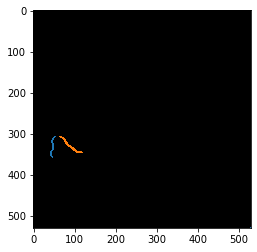

In [57]:
import gif 

gif.plot_gif(labeled_images, '../22956819/gif/A6_seg_4.gif')

## GNN tracking model

In [58]:
##### Try Well C3

In [59]:
ROOT_DIR = '../track_train/attempt_4'  # TODO: Change this! Usually a mounted volume

MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models'))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs'))
#DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
OUTPUT_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'nuc_tracking'))

In [60]:
from deepcell.model_zoo.tracking import GNNTrackingModel

tm = GNNTrackingModel(max_cells=20, n_layers=1)

In [61]:
inf_path = os.path.join(MODEL_DIR, 'TrackingModelInf')
ne_path = os.path.join(MODEL_DIR, 'TrackingModelNE')

tm.inference_model.load_weights(inf_path)
tm.neighborhood_encoder.load_weights(ne_path)

In [62]:
# Choose and load a dataset to track using the trained model

raw_images = np.load("../22956819/A6_raw_4.npy")
labeled_movie = np.load("../22956819/A6_seg_4.npy")

In [63]:
from deepcell_tracking import CellTracker

cell_tracker = CellTracker(
    movie=raw_images,
    annotation=labeled_movie,
    track_length=8,
    neighborhood_encoder=tm.neighborhood_encoder,
    tracking_model=tm.inference_model)

In [64]:
%%time

cell_tracker.track_cells()

CPU times: user 12min 5s, sys: 15min 49s, total: 27min 55s
Wall time: 22.1 s


In [65]:
cell_tracker.y_tracked.shape

(100, 530, 530, 1)

In [66]:
track = cell_tracker.y_tracked

[0 1]


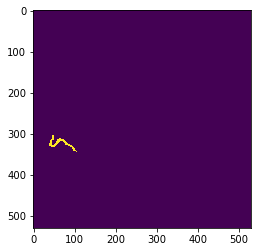

In [67]:
print(np.unique(track[1]))
plt.imshow(track[0])

unique_worm_ids:  [1, 2]
sequential ids:  [1, 2]


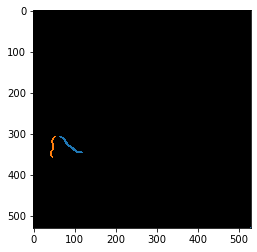

In [68]:
import gif

gif.plot_gif(track, '../22956819/gif/A6_track_4.gif')

In [69]:
np.save("../22956819/A6_track_4.npy", track)